# Aggregate cell profiles to well-level profiles

In [245]:
# imports
import os
import glob
import operator
import random
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from functools import reduce
from pycytominer.feature_select import feature_select
# from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import networkx as nx
import community.community_louvain as community_louvain
from kneed import KneeLocator
import umap

import sys
sys.path.append("../..")
from img_utils import *
sys.path.append("../../2.snakemake_pipeline")
from utils import inverse_normal_transform

random.seed(0)
np.random.seed(0)

letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}
channel_list = list(channel_dict_rev.values())[:-3]

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
AUROC_THRESHOLDS = [0.95, 0.99]

## 1. Get the allele info

In [78]:
clin_var_df = pl.read_csv(f"../inputs/varchamp_seq_confirm_alleles_clinvar_gnomad_dbnsfp_struc_scores_OMIM_MOI_disease_modules_with_protein_features.tsv", 
                          separator="\t", infer_schema_length=10000
).with_columns(
    pl.col("symbol").str.replace_all("\s+", "").alias("symbol")
).with_columns(
    pl.concat_str([
        pl.col("symbol"),
        pl.col("aa_change")
    ], separator="_").alias("gene_allele")
)

imaging_summary = pl.read_csv("../outputs/2.classification_results/imaging_analyses_classification_summary_all.csv")
## merge the data frames
imaging_summary_clinvar = imaging_summary.join(
    clin_var_df.unique("gene_allele"),
    on="gene_allele",
    how="left"
).with_columns(
    pl.when(pl.col("clinvar_clnsig_clean").is_null())
    .then(pl.lit("6_No_ClinVar"))
    .otherwise(pl.col("clinvar_clnsig_clean"))
    .alias("clinvar_clnsig_clean")
)
imaging_summary_clinvar.head()

symbol,gene_allele,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP_ADJ,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP_ADJ,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP_ADJ,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep1_GFP_ADJ,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP,AUROC_BioRep2_GFP_ADJ,symbol_right,ensembl_gene_id,orf_id,mut_id,…,protein_00001206-a-2 outliers⁺⁺,protein_00000095-a-1 avg,protein_00000095-a-1 outliers⁺⁺,protein_00000095-b-1 avg,protein_00000095-b-1 outliers⁺⁺,protein_00001087-a-1 avg,protein_00001087-a-1 outliers⁺⁺,protein_00000112-a-1 avg,protein_00000112-a-1 outliers⁺⁺,protein_00000745-a-1 avg,protein_00000745-a-1 outliers⁺⁺,protein_00000746-a-1 avg,protein_00000746-a-1 outliers⁺⁺,protein_00000091-a-1 avg,protein_00000091-a-1 outliers⁺⁺,protein_00000708-a-1 avg,protein_00000708-a-1 outliers⁺⁺,protein_00000659-a-1 avg,protein_00000659-a-1 outliers⁺⁺,protein_00001062-a-1 avg,protein_00001062-a-1 outliers⁺⁺,protein_00000013-a-1 avg,protein_00000013-a-1 outliers⁺⁺,protein_00000101-a-1 avg,protein_00000101-a-1 outliers⁺⁺,protein_00000102-0-1 avg,protein_00000102-0-1 outliers⁺⁺,protein_00000966-a-1 avg,protein_00000966-a-1 outliers⁺⁺,protein_00000686-a-1 avg,protein_00000686-a-1 outliers⁺⁺,protein_00000959-a-1 avg,protein_00000959-a-1 outliers⁺⁺,protein_00001053-a-1 avg,protein_00001053-a-1 outliers⁺⁺,protein_00001082-a-1 avg,protein_00001082-a-1 outliers⁺⁺
str,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,i64,f64,…,str,f64,str,f64,str,str,str,f64,str,f64,str,f64,str,f64,str,str,str,f64,str,str,str,f64,str,f64,str,f64,str,str,str,str,str,str,str,f64,str,f64,str
"""GBA""","""GBA_Leu410Val""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,false,false,0.928839,0.910359,0.502689,0.727919,0.754571,0.605476,0.581863,0.665995,0.667792,0.487936,0.855773,0.8906,0.629088,0.843147,0.788047,0.517441,0.964946,0.967077,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""GBA""","""GBA_Leu279Val""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,false,false,0.768654,0.777555,0.482701,0.677927,0.694485,0.566354,0.554518,0.733437,0.629172,0.445675,0.786461,0.797264,0.57819,0.655533,0.726682,0.519728,0.768649,0.740044,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""RABGEF1""","""RABGEF1_Glu191Lys""","""2025_06_Batch_18-19""",false,false,false,false,true,false,false,false,false,false,false,false,0.886866,0.887425,0.768008,0.877752,0.950649,0.906481,0.94508,0.967178,0.933369,0.868459,0.946198,0.932814,0.867883,0.934119,0.822135,0.667558,0.828651,0.840918,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""ARFGAP3""","""ARFGAP3_Val320Leu""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,false,false,0.927558,0.964106,0.66526,0.903111,0.913784,0.857217,0.911318,0.948168,0.922622,0.785607,0.955733,0.917982,0.803116,0.8794,0.883601,0.544914,0.972478,0.937133

symbol,gene_allele,Metadata_Bio_Batch,Altered_95th_perc_both_batches_GFP_ADJ,Altered_95th_perc_both_batches_GFP,Altered_95th_perc_both_batches_DNA,Altered_95th_perc_both_batches_Mito,Altered_95th_perc_both_batches_AGP,Altered_95th_perc_both_batches_Morph,Altered_99th_perc_both_batches_GFP_ADJ,Altered_99th_perc_both_batches_GFP,Altered_99th_perc_both_batches_DNA,Altered_99th_perc_both_batches_Mito,Altered_99th_perc_both_batches_AGP,Altered_99th_perc_both_batches_Morph,AUROC_Mean_GFP_ADJ,AUROC_Mean_GFP,AUROC_Mean_DNA,AUROC_Mean_Mito,AUROC_Mean_AGP,AUROC_Mean_Morph,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep1_GFP,AUROC_BioRep1_GFP_ADJ,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_BioRep2_GFP,AUROC_BioRep2_GFP_ADJ
str,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""GBA""","""GBA_Leu410Val""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,false,false,0.928839,0.910359,0.502689,0.727919,0.754571,0.605476,0.581863,0.665995,0.667792,0.487936,0.855773,0.8906,0.629088,0.843147,0.788047,0.517441,0.964946,0.967077
"""GBA""","""GBA_Leu279Val""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,false,false,0.768654,0.777555,0.482701,0.677927,0.694485,0.566354,0.554518,0.733437,0.629172,0.445675,0.786461,0.797264,0.57819,0.655533,0.726682,0.519728,0.768649,0.740044
"""RABGEF1""","""RABGEF1_Glu191Lys""","""2025_06_Batch_18-19""",false,false,false,false,true,false,false,false,false,false,false,false,0.886866,0.887425,0.768008,0.877752,0.950649,0.906481,0.94508,0.967178,0.933369,0.868459,0.946198,0.932814,0.867883,0.934119,0.822135,0.667558,0.828651,0.840918
"""ARFGAP3""","""ARFGAP3_Val320Leu""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,false,false,0.927558,0.964106,0.66526,0.903111,0.913784,0.857217,0.911318,0.948168,0.922622,0.785607,0.955733,0.917982,0.803116,0.8794,0.883601,0.544914,0.972478,0.937133
"""KCNK18""","""KCNK18_Arg10Gly""","""2025_06_Batch_18-19""",false,false,false,false,false,false,false,false,false,false,false,false,0.677421,0.704844,0.515855,0.624806,0.690363,0.548778,0.463197,0.651734,0.57028,0.481268,0.644532,0.640076,0.63436,0.728993,0.679332,0.550442,0.765155,0.714766
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""HPRT1""","""HPRT1_Gly58Arg""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,false,false,0.624638,0.635361,0.781656,0.791873,0.747227,0.83983,0.918279,0.820936,0.900481,0.860613,0.721486,0.760672,0.76138,0.673518,0.683264,0.702698,0.549236,0.488603
"""EMD""","""EMD_Pro183His""","""2024_01_Batch_7-8""",null,true,false,false,false,false,null,false,false,false,false,false,null,0.971264,0.616782,0.731877,0.530908,0.625977,null,null,null,null,null,null,0.625977,0.530908,0.731877,0.616782,0.971264,null
"""GCK""","""GCK_Gly175Arg""","""2024_01_Batch_7-8""",false,false,false,false,false,false,false,false,false,false,false,false,0.79691,0.880137,0.68718,0.755855,0.588094,0.717738,0.717738,0.588094,0.755855,0.68718,0.880137,0.79691,null,null,null,null,null,null


In [79]:
clin_var_df.select([
    "gene_allele", 
    'clinvar_OMIM_id', 'OMIM_IDs', 'OMIM_disease_names',
    'disease_modules', 'disease_module_count'
]).write_csv("../inputs/disease_modules.csv")

In [80]:
misloc_ref_var_alleles = list(imaging_summary_clinvar.filter(pl.col("Altered_95th_perc_both_batches_GFP_ADJ")).unique("gene_allele")["gene_allele"])
misloc_ref_var_alleles += list(set([gene_allele.split('_')[0] for gene_allele in misloc_ref_var_alleles]))

all_ref_var_alleles = list(imaging_summary_clinvar.unique("gene_allele")["gene_allele"])
all_ref_var_alleles += list(set([gene_allele.split('_')[0] for gene_allele in all_ref_var_alleles]))

## 2. Single-cell imaging profiles

In [5]:
allele_meta_df = pl.read_csv(IMG_METADATA_FILE, infer_schema_length=10000)
img_well_qc_sum_df = pl.read_csv(IMG_QC_SUM_DF_FILE, infer_schema_length=10000)

with open(IMG_METADATA_DICT_FILE, "rb") as f:
    allele_meta_df_dict = pickle.load(f)

with open(IMG_QC_SUM_DICT_FILE, "rb") as f:
    img_well_qc_sum_dict = pickle.load(f)

### 2.1 Processing filtered single-cell imaging profiles for storage

In [6]:
meta_cols = [
    "Metadata_CellID",
    "Metadata_gene_allele",
    "Metadata_Well",
    "Metadata_Plate",
    "Metadata_node_type",
    "Metadata_bio_batch"
]
# Paths
feat = "GFP"

In [7]:
pass_qc_prof_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
sc_profile_gfp_df = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                pass_qc_prof_dir.format(PROF_DIR, batch_id)
            )
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID"),
                pl.lit(bio_rep).alias("Metadata_bio_batch"),
                pl.col("Metadata_gene_allele").str.replace_all("\s+", "").alias("Metadata_gene_allele")
            )
            .filter(
                pl.col("Metadata_gene_allele").is_in(all_ref_var_alleles)
            )
            .select(meta_cols)
        ).collect()
        # feat_cols = [col for col in batch_alleles.columns if feat.lower() in col.lower() and "Brightfield" not in col]
        batch_alleles = batch_alleles.join(
            img_well_qc_sum_dict[bio_rep].filter(pl.col("channel")==feat).select(pl.col("plate", "well", "is_bg")),
            left_on=["Metadata_Plate", "Metadata_Well"],
            right_on=["plate", "well"]
        ).filter(
            ~pl.col("is_bg")
        ).select(
            pl.col(meta_cols)
        )
        sc_profile_gfp_df = pl.concat([sc_profile_gfp_df, batch_alleles])

In [8]:
# Paths
pass_qc_gfp_filt_prof_dir = CLASS_RESULTS_DIR+"/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/gfp_adj_filtered_cells_profiles.parquet"
sc_profile_gfp_filt_df = pl.DataFrame()

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                pass_qc_gfp_filt_prof_dir.format(batch_id)
            )
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID"),
                pl.lit(bio_rep).alias("Metadata_bio_batch"),
                pl.col("Metadata_gene_allele").str.replace_all("\s+", "").alias("Metadata_gene_allele")
            )
            .filter(
                pl.col("Metadata_gene_allele").is_in(all_ref_var_alleles)
            )
            .select(meta_cols+["Metadata_refvar_gfp_adj_classify"])
        ).collect()
        batch_alleles = batch_alleles.join(
            img_well_qc_sum_dict[bio_rep].filter(pl.col("channel")==feat).select(pl.col("plate", "well", "is_bg")),
            left_on=["Metadata_Plate", "Metadata_Well"],
            right_on=["plate", "well"]
        ).filter(
            ~pl.col("is_bg")
        ).select(pl.col(meta_cols+["Metadata_refvar_gfp_adj_classify"]))
        sc_profile_gfp_filt_df = pl.concat([sc_profile_gfp_filt_df, batch_alleles])

In [9]:
# Paths
prof_var_mad_outlier_path = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier.parquet"
sc_all_profile_gfp_df_list = []

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        batch_alleles = (
            pl.scan_parquet(
                prof_var_mad_outlier_path.format(PROF_DIR, batch_id)
            )
            .with_columns(
                pl.concat_str(
                    [
                        "Metadata_Plate",
                        "Metadata_Well",
                        "Metadata_ImageNumber",
                        "Metadata_ObjectNumber",
                    ],
                    separator="_",
                ).alias("Metadata_CellID")
            )
        )
        feat_cols = [col for col in batch_alleles.collect_schema().names() if feat.lower() in col.lower() and "Brightfield" not in col]
        batch_alleles = batch_alleles.select(pl.col(["Metadata_CellID"]+feat_cols))
        sc_all_profile_gfp_df_list.append(batch_alleles)

In [10]:
# list GFP columns that are not present in every LazyFrame in `sc_all_profile_gfp_df_list`
# collect schemas (dict-like: col -> dtype) for each lazyframe
schemas = [lf.collect_schema() for lf in sc_all_profile_gfp_df_list]
n_frames = len(schemas)

# find all columns containing "gfp" (case-insensitive) across all schemas
all_gfp_cols = sorted({col for sch in schemas for col in sch.keys() if "gfp" in col.lower()})

# build presence map: col -> list(bool) indicating presence in each frame
presence = {col: [(col in sch) for sch in schemas] for col in all_gfp_cols}

# select columns not present in all frames
not_all_cols = [col for col, pres in presence.items() if sum(pres) != n_frames]

# print summary
print(f"Number of lazy frames: {n_frames}")
print(f"Total GFP-like columns found across all frames: {len(all_gfp_cols)}")
print(f"GFP-like columns missing from at least one frame: {len(not_all_cols)}\n")

print("Columns (present_count / total) that are NOT in every frame:")
# for col in not_all_cols:
#     print(f" - {col} : {sum(presence[col])}/{n_frames}")

# optional: show a compact presence matrix (columns x frames)
presence_df = pd.DataFrame.from_dict(presence, orient="index",
                                    columns=[f"frame_{i}" for i in range(n_frames)])
print("\nPresence matrix (True = present, False = missing):")
display(presence_df.loc[not_all_cols])

Number of lazy frames: 10
Total GFP-like columns found across all frames: 591
GFP-like columns missing from at least one frame: 147

Columns (present_count / total) that are NOT in every frame:

Presence matrix (True = present, False = missing):


,frame_0,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9
Cells_Correlation_K_AGP_GFP,False,False,True,True,False,False,False,False,False,False
Cells_Correlation_K_GFP_AGP,False,False,True,True,True,True,False,False,False,False
Cells_Correlation_Manders_AGP_GFP,False,False,False,False,True,True,True,True,False,False
Cells_Correlation_Manders_DNA_GFP,False,False,False,False,True,True,False,False,False,False
Cells_Correlation_Manders_GFP_DNA,True,False,True,True,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...
Nuclei_Texture_SumEntropy_GFP_20_03_256,True,False,True,True,False,False,True,True,False,False
Nuclei_Texture_SumEntropy_GFP_5_00_256,True,True,True,True,True,True,True,True,True,False
Nuclei_Texture_SumEntropy_GFP_5_01_256,True,True,True,True,True,True,True,True,True,False
Nuclei_Texture_SumEntropy_GFP_5_02_256,True,True,True,True,True,True,True,True,True,False


In [11]:
# Determine common columns across all lazyframes and select only those before concatenation
# collect schemas for each lazyframe (mapping-like: col -> dtype)
schemas = [lf.collect_schema() for lf in sc_all_profile_gfp_df_list]
# intersection of column names present in every schema
common_cols = set.intersection(*[set(sch.keys()) for sch in schemas]) if schemas else set()
# preserve meta_cols order first, then feature order from the first schema
first_keys = list(schemas[0].keys()) if schemas else []
common_meta = [c for c in meta_cols if c in common_cols]
feat_common = [c for c in first_keys if (c in common_cols and c not in common_meta)]

keep_cols = common_meta + feat_common
if not keep_cols:
    raise ValueError("No common columns found across lazyframes; aborting concat.")

print(f"Selecting {len(keep_cols)} common columns for concatenation (meta cols: {len(common_meta)})")
# select the common columns from each lazyframe (use pl.col to produce expressions)
sc_list_selected = [lf.select([pl.col(c) for c in keep_cols]) for lf in sc_all_profile_gfp_df_list]
# safe diagonal concat of the selected lazyframes
sc_all_profile_gfp_df = pl.concat(sc_list_selected, how="diagonal")

Selecting 445 common columns for concatenation (meta cols: 1)


In [12]:
qc_sc_prof_gfp_df = sc_profile_gfp_df.join(
    sc_all_profile_gfp_df.collect(),
    on="Metadata_CellID",
    how="left"
)

qc_sc_prof_gfp_filt_df = sc_profile_gfp_filt_df.join(
    sc_all_profile_gfp_df.collect(),
    on="Metadata_CellID",
    how="left"
)

In [ ]:
# # Comment out if want to update stored files
# qc_sc_prof_gfp_df.write_parquet("../../2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_all.parquet")
# qc_sc_prof_gfp_filt_df.write_parquet("../../2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_all_gfp_filtered.parquet")

### 2.2 Loading stored single-cell imaging profiles

In [14]:
qc_sc_prof_gfp_df = pl.read_parquet("../../2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_all.parquet")
qc_sc_prof_gfp_filt_df = pl.read_parquet("../../2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_all_gfp_filtered.parquet")

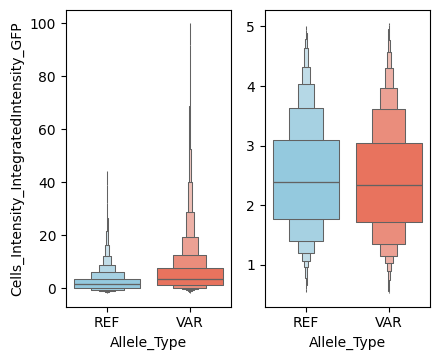

In [360]:
fig, ax = plt.subplots(1,2,figsize=(4.5,3.7))
sns.boxenplot(
    data=qc_sc_prof_gfp_df.filter(
        (pl.col("Metadata_gene_allele")=="CCM2_Val53Ile")|(pl.col("Metadata_gene_allele")=="CCM2"),
        pl.col("Metadata_bio_batch")=="2025_06_Batch_18-19"
    ).with_columns(
        pl.when(pl.col("Metadata_gene_allele")=="CCM2")
        .then(pl.lit("REF"))
        .otherwise(pl.lit("VAR"))
        .alias("Allele_Type")
    ).to_pandas(),
    order=["REF","VAR"],
    x="Allele_Type",
    y="Cells_Intensity_IntegratedIntensity_GFP",
    ax=ax[0],
    showfliers=False,
    outlier_prop=0,
    hue="Allele_Type",
    hue_order=["REF","VAR"],
    palette=["skyblue","tomato"]
    # cut=0
)
sns.boxenplot(
    data=qc_sc_prof_gfp_filt_df.filter(
        (pl.col("Metadata_refvar_gfp_adj_classify").str.contains("CCM2_Val53Ile"))
    ).with_columns(
        pl.when(pl.col("Metadata_gene_allele")=="CCM2")
        .then(pl.lit("REF"))
        .otherwise(pl.lit("VAR"))
        .alias("Allele_Type")
    ).to_pandas(),
    order=["REF","VAR"],
    x="Allele_Type",
    y="Cells_Intensity_IntegratedIntensity_GFP",
    ax=ax[1],
    outlier_prop=0,
    showfliers=False,
    hue="Allele_Type",
    palette=["skyblue","tomato"]
    # cut=0
)
ax[1].set_ylabel("")
plt.tight_layout()
plt.savefig("test.png",dpi=400)

In [332]:
qc_sc_prof_gfp_filt_df

Metadata_CellID,Metadata_gene_allele,Metadata_Well,Metadata_Plate,Metadata_node_type,Metadata_bio_batch,Metadata_refvar_gfp_adj_classify,Cells_Texture_AngularSecondMoment_GFP_20_02_256,Cytoplasm_RadialDistribution_MeanFrac_GFP_10of10,Cells_Texture_InfoMeas1_GFP_10_00_256,Cells_Texture_InverseDifferenceMoment_GFP_5_02_256,Nuclei_RadialDistribution_FracAtD_GFP_10of10,Nuclei_Texture_Correlation_GFP_10_02_256,Nuclei_Texture_InverseDifferenceMoment_GFP_5_00_256,Cells_RadialDistribution_MeanFrac_GFP_5of10,Cytoplasm_Texture_InverseDifferenceMoment_GFP_20_02_256,Nuclei_RadialDistribution_RadialCV_GFP_6of10,Cells_Texture_AngularSecondMoment_GFP_20_01_256,Cells_Correlation_Correlation_GFP_Mito,Nuclei_Texture_AngularSecondMoment_GFP_20_02_256,Cytoplasm_Texture_SumEntropy_GFP_20_01_256,Cytoplasm_Texture_DifferenceEntropy_GFP_10_00_256,Cells_Intensity_UpperQuartileIntensity_GFP,Nuclei_RadialDistribution_RadialCV_GFP_5of10,Nuclei_Texture_Correlation_GFP_20_00_256,Cytoplasm_RadialDistribution_MeanFrac_GFP_2of10,Cells_Texture_SumEntropy_GFP_10_00_256,Cells_RadialDistribution_FracAtD_GFP_10of10,Cells_Texture_Entropy_GFP_10_00_256,Nuclei_Texture_DifferenceVariance_GFP_5_00_256,Nuclei_RadialDistribution_RadialCV_GFP_9of10,Cells_Texture_DifferenceEntropy_GFP_5_00_256,Nuclei_Texture_AngularSecondMoment_GFP_20_03_256,Nuclei_Texture_DifferenceVariance_GFP_20_03_256,Cells_Texture_InfoMeas1_GFP_5_02_256,Cytoplasm_RadialDistribution_RadialCV_GFP_10of10,Cytoplasm_Texture_Correlation_GFP_5_00_256,…,Cytoplasm_Texture_DifferenceVariance_GFP_20_02_256,Cytoplasm_Texture_DifferenceEntropy_GFP_5_01_256,Nuclei_Correlation_RWC_GFP_DNA,Nuclei_Intensity_MassDisplacement_GFP,Nuclei_Intensity_MeanIntensityEdge_GFP,Cells_Texture_SumEntropy_GFP_20_00_256,Nuclei_Location_MaxIntensity_X_GFP,Nuclei_Texture_InverseDifferenceMoment_GFP_5_03_256,Cytoplasm_Texture_Entropy_GFP_20_03_256,Cytoplasm_Texture_Correlation_GFP_10_03_256,Cytoplasm_RadialDistribution_FracAtD_GFP_9of10,Nuclei_Texture_Correlation_GFP_20_01_256,Cytoplasm_Texture_InfoMeas2_GFP_10_03_256,Cytoplasm_Granularity_3_GFP,Cytoplasm_Texture_InfoMeas2_GFP_20_01_256,Cells_Texture_InverseDifferenceMoment_GFP_5_01_256,Cytoplasm_Granularity_1_GFP,Cytoplasm_Texture_DifferenceVariance_GFP_5_00_256,Nuclei_Texture_InverseDifferenceMoment_GFP_20_02_256,Cells_Texture_Entropy_GFP_5_02_256,Cytoplasm_Texture_InverseDifferenceMoment_GFP_20_00_256,Nuclei_Correlation_Overlap_AGP_GFP,Nuclei_Texture_InverseDifferenceMoment_GFP_10_03_256,Cytoplasm_Texture_AngularSecondMoment_GFP_5_02_256,Cytoplasm_Texture_InverseDifferenceMoment_GFP_5_00_256,Cytoplasm_Texture_InfoMeas2_GFP_10_02_256,Nuclei_Location_CenterMassIntensity_X_GFP,Cells_Granularity_2_GFP,Cells_Location_CenterMassIntensity_Y_GFP,Cells_Granularity_5_GFP,Cytoplasm_RadialDistribution_MeanFrac_GFP_6of10,Cells_RadialDistribution_MeanFrac_GFP_6of10,Cytoplasm_Texture_DifferenceEntropy_GFP_10_02_256,Cells_Correlation_RWC_Mito_GFP,Cytoplasm_RadialDistribution_FracAtD_GFP_7of10,Cells_RadialDistribution_MeanFrac_GFP_10of10,Cells_RadialDistribution_RadialCV_GFP_1of10
str,str,str,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""2024_01_17_B7A1R1_P1T1_E07_924…","""AGXT""","""E07""","""2024_01_17_B7A1R1_P1T1""","""disease_wt""","""2024_01_Batch_7-8""","""AGXT_AGXT_Ala186Val_E07-M13_q0…",-0.651452,-2.972931,-3.229723,-0.196419,1.188086,-0.055134,0.372359,-0.76242,-0.384614,0.25168,-0.49772,0.036289,1.226659,0.529842,0.186296,1.576042,0.470888,-0.360262,-0.020876,0.609731,-0.351107,0.563733,0.464003,-0.460019,0.118556,0.728733,1.554742,-1.670162,-0.406906,0.939008,…,-0.33437,0.045967,1.720938,-0.133664,0.858727,0.569618,-1.562264,0.380377,0.908108,0.342858,3.449248,-0.163863,0.770641,0.526042,1.711348,0.086718,-0.938057,0.151953,0.446719,0.598881,-0.14375,

In [15]:
print(qc_sc_prof_gfp_filt_df.shape)
print(qc_sc_prof_gfp_df.shape)

(4252079, 451)
(5524133, 450)


## 3. Processing and profiling

### 3.1 Calculate the Z-score normalized imaging profiled features

In [109]:
gfp_feats = [col for col in qc_sc_prof_gfp_df.columns if not col.startswith("Metadata_")]
var_zscore_sc_feat_df, var_zscore_feat_df = pl.DataFrame(), pl.DataFrame()

for gene in tqdm(imaging_summary_clinvar["symbol"].unique()):
    ## Normalized Z-score by batch
    # print(qc_sc_prof_gfp_df.filter(pl.col("Metadata_gene_allele")==gene)["Metadata_bio_batch"].unique())
    for bio_batch in qc_sc_prof_gfp_df.filter(pl.col("Metadata_gene_allele")==gene)["Metadata_bio_batch"].unique():
        # print(bio_batch)
        gene_mean = qc_sc_prof_gfp_df.filter(
            pl.col("Metadata_gene_allele")==gene,
            pl.col("Metadata_bio_batch")==bio_batch,
        ).select(gfp_feats).mean().to_numpy()[0].tolist()
        gene_std = qc_sc_prof_gfp_df.filter(
            pl.col("Metadata_gene_allele")==gene,
            pl.col("Metadata_bio_batch")==bio_batch,
        ).select(gfp_feats).std().to_numpy()[0].tolist()
        # print(gene_mean, gene_std)
        ## ONLY selecting valid variants in the batch
        valid_variant_in_batch = imaging_summary_clinvar.filter(
            (pl.col("Metadata_Bio_Batch")==bio_batch)&(pl.col("gene_allele").str.starts_with(f"{gene}_"))
        )["gene_allele"].unique()
        ## Z-score normalized sc feature
        z_norm_var_sc_feat_df = qc_sc_prof_gfp_df.filter(
            (pl.col("Metadata_gene_allele").is_in(valid_variant_in_batch))
            &(pl.col("Metadata_bio_batch")==bio_batch)
        ).with_columns(
            [((pl.col(col) - pl.lit(gene_mean[i])) / pl.lit(gene_std[i])).alias(col)
            for i, col in enumerate(gfp_feats)]
        )
        var_zscore_sc_feat_df = pl.concat([
            var_zscore_sc_feat_df,
            z_norm_var_sc_feat_df
        ])

        ## Aggregated to var level
        z_norm_var_feat_df = z_norm_var_sc_feat_df.group_by(
            "Metadata_gene_allele", "Metadata_Plate", "Metadata_Well" ## aggregate by well first
        ).agg(
            pl.col(col).median().alias(col)
            for col in gfp_feats
        ).group_by(
            "Metadata_gene_allele" ## aggregate by allele
        ).agg(
            pl.col(col).median().alias(col)
            for col in gfp_feats
        )#.to_pandas().set_index("Metadata_gene_allele")[sig_diff_feat]
        
        var_zscore_feat_df = pl.concat(
            [var_zscore_feat_df, z_norm_var_feat_df], 
            how="diagonal"
        )

100%|██████████| 173/173 [02:00<00:00,  1.44it/s]


In [111]:
gfp_feats_filtered = [col for col in qc_sc_prof_gfp_filt_df.columns if not col.startswith("Metadata_")]
var_zscore_sc_feat_gfp_filtered_df, var_zscore_feat_gfp_filtered_df = pl.DataFrame(), pl.DataFrame()

for gene in tqdm(imaging_summary_clinvar["symbol"].unique()):
    ## Normalized Z-score by batch
    for bio_batch in qc_sc_prof_gfp_filt_df.filter(pl.col("Metadata_gene_allele")==gene)["Metadata_bio_batch"].unique():
        gene_mean = qc_sc_prof_gfp_filt_df.filter(
            pl.col("Metadata_gene_allele")==gene,
            pl.col("Metadata_bio_batch")==bio_batch,
        ).select(gfp_feats_filtered).mean().to_numpy()[0].tolist()
        gene_std = qc_sc_prof_gfp_filt_df.filter(
            pl.col("Metadata_gene_allele")==gene,
            pl.col("Metadata_bio_batch")==bio_batch,
        ).select(gfp_feats_filtered).std().to_numpy()[0].tolist()
        # print(gene_mean, gene_std)
        ## ONLY selecting valid variants in the batch
        valid_variant_in_batch = imaging_summary_clinvar.filter(
            (pl.col("Metadata_Bio_Batch")==bio_batch)&(pl.col("gene_allele").str.starts_with(f"{gene}_"))
        )["gene_allele"].unique()
        ## Z-score normalized sc feature
        z_norm_var_sc_feat_df = qc_sc_prof_gfp_filt_df.filter(
            (pl.col("Metadata_gene_allele").is_in(valid_variant_in_batch))
            &(pl.col("Metadata_bio_batch")==bio_batch)
        ).with_columns(
            [((pl.col(col) - pl.lit(gene_mean[i])) / pl.lit(gene_std[i])).alias(col)
            for i, col in enumerate(gfp_feats_filtered)]
        )
        var_zscore_sc_feat_gfp_filtered_df = pl.concat([
            var_zscore_sc_feat_gfp_filtered_df,
            z_norm_var_sc_feat_df
        ])

        ## Aggregated to var level
        z_norm_var_feat_df = z_norm_var_sc_feat_df.group_by(
            "Metadata_gene_allele", "Metadata_Plate", "Metadata_Well" ## aggregate by well first
        ).agg(
            pl.col(col).median().alias(col)
            for col in gfp_feats_filtered
        ).group_by(
            "Metadata_gene_allele" ## aggregate by allele
        ).agg(
            pl.col(col).median().alias(col)
            for col in gfp_feats_filtered
        )#.to_pandas().set_index("Metadata_gene_allele")[sig_diff_feat]
        
        var_zscore_feat_gfp_filtered_df = pl.concat(
            [var_zscore_feat_gfp_filtered_df, z_norm_var_feat_df], 
            how="diagonal"
        )

100%|██████████| 173/173 [01:43<00:00,  1.67it/s]


In [ ]:
# var_zscore_sc_feat_df.write_parquet("../../2.snakemake_pipeline/outputs/var_gfp_feat_sc_zscore_all.parquet")
# var_zscore_feat_df.write_parquet("../../2.snakemake_pipeline/outputs/var_gfp_feat_zscore_all.parquet")
# var_zscore_sc_feat_gfp_filtered_df.write_parquet("../../2.snakemake_pipeline/outputs/var_gfp_filtered_feat_sc_zscore_all.parquet")
# var_zscore_feat_gfp_filtered_df.write_parquet("../../2.snakemake_pipeline/outputs/var_gfp_filtered_feat_zscore_all.parquet")

### 3.2 Loading Z-scored imaging profiles

In [246]:
var_zscore_sc_feat_df = pl.read_parquet("../../2.snakemake_pipeline/outputs/var_gfp_feat_sc_zscore_all.parquet")
var_zscore_feat_df = pl.read_parquet("../../2.snakemake_pipeline/outputs/var_gfp_feat_zscore_all.parquet")
var_zscore_sc_feat_gfp_filtered_df = pl.read_parquet("../../2.snakemake_pipeline/outputs/var_gfp_filtered_feat_sc_zscore_all.parquet")
var_zscore_feat_gfp_filtered_df = pl.read_parquet("../../2.snakemake_pipeline/outputs/var_gfp_filtered_feat_zscore_all.parquet")

## 4. Clustering Analysis

In [247]:
var_zscore_feat_gfp_filtered_int_df = inverse_normal_transform(var_zscore_feat_gfp_filtered_df)
var_zscore_feat_gfp_filtered_int_feat_sel_df = feature_select(
    var_zscore_feat_gfp_filtered_int_df.to_pandas(), operation="variance_threshold"
)
var_zscore_feat_gfp_filtered_int_feat_sel_df = pl.DataFrame(
    feature_select(var_zscore_feat_gfp_filtered_int_feat_sel_df, operation="correlation_threshold")
)
## Append important medadata to data frame
cols = [
    "gene_allele",
    "Metadata_Bio_Batch",
    "Altered_95th_perc_both_batches_GFP_ADJ",
    "AUROC_Mean_GFP_ADJ",
    "clinvar_OMIM_id",
    "OMIM_IDs",
    "OMIM_disease_names",
]
var_zscore_feat_gfp_filtered_int_feat_sel_df = var_zscore_feat_gfp_filtered_int_feat_sel_df.join(
    imaging_summary_clinvar.select(cols).rename(
        {k: f"Metadata_{k}" for k in cols if "Metadata" not in k}
    ),
    on="Metadata_gene_allele",
    how="inner"
)

  0%|          | 0/444 [00:00<?, ?it/s]

### 4.1 DR (PCA and UMAP)

In [248]:
df = var_zscore_feat_gfp_filtered_int_feat_sel_df.select(pl.col([col for col in var_zscore_feat_gfp_filtered_int_feat_sel_df.columns if not col.startswith("Metadata_")]))

# Standardize the features before PCA
df = pd.DataFrame(df, columns=df.columns, index=var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_gene_allele"])

# Generate k-NN graph
k = 25  # adjust based on testing
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine')
nbrs.fit(df.to_numpy())
distances, indices = nbrs.kneighbors(df.to_numpy())

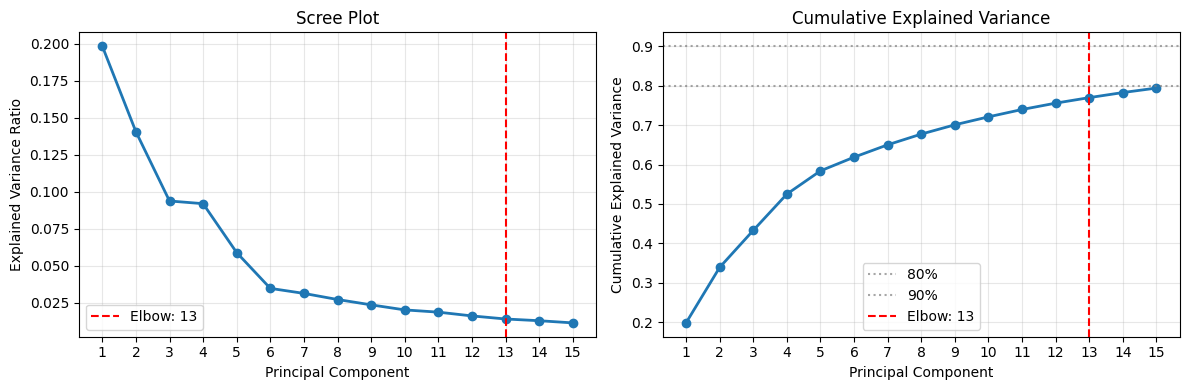

Optimal components: 13
Explained variance at elbow: 77.0%


In [249]:
# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(df)

# Calculate variances
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find elbow point using KneeLocator
knee_locator = KneeLocator(
    range(1, len(explained_variance_ratio)+1),
    explained_variance_ratio,
    curve='convex',
    direction='decreasing'
)
optimal_components = knee_locator.knee

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot
n_show = min(15, len(explained_variance_ratio))
ax1.plot(range(1, n_show + 1), explained_variance_ratio[:n_show], 'o-', linewidth=2)
ax1.axvline(x=optimal_components, color='red', linestyle='--', label=f'Elbow: {optimal_components}')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot')
ax1.set_xticks(range(1, n_show + 1))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative variance plot
ax2.plot(range(1, n_show + 1), cumulative_variance[:n_show], 'o-', linewidth=2)
ax2.axhline(y=0.8, color='gray', linestyle=':', alpha=0.7, label='80%')
ax2.axhline(y=0.9, color='gray', linestyle=':', alpha=0.7, label='90%')
ax2.axvline(x=optimal_components, color='red', linestyle='--', label=f'Elbow: {optimal_components}')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xticks(range(1, n_show + 1))
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results
print(f"Optimal components: {optimal_components}")
print(f"Explained variance at elbow: {cumulative_variance[optimal_components-1]:.1%}")

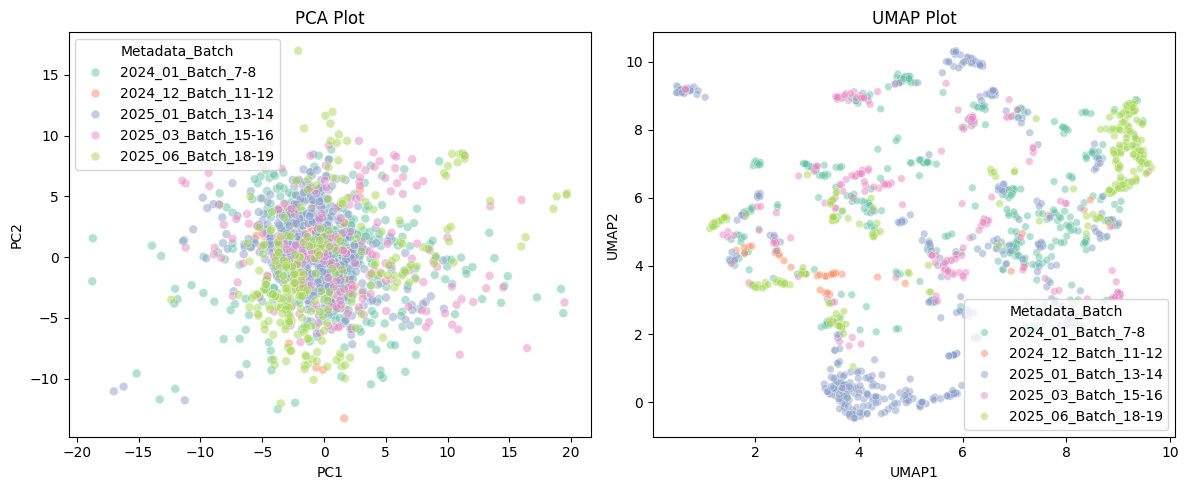

In [250]:
# Apply optimal PCA
pca = PCA() ## n_components=optimal_components
data_pca = pca.fit_transform(df.to_numpy())

pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pca_df["Metadata_gene_allele"] = var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_gene_allele"].to_numpy()
pca_df["Metadata_Batch"] = var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_Bio_Batch"].to_numpy()

# Perform UMAP on top PCs
umap_model = umap.UMAP(
    n_neighbors=k, 
    min_dist=0.1, 
    n_components=2, 
    random_state=42, 
    n_jobs=1, 
    metric='cosine'
)
umap_result = umap_model.fit_transform(
    df.to_numpy(), knn_indices=indices, knn_dists=distances
)
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["Metadata_Batch"] = var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_Bio_Batch"].to_numpy()

# Plot UMAP
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=pca_df.sort_values(by="Metadata_Batch"), alpha=.5,
                x="PC1", y="PC2", hue="Metadata_Batch", palette="Set2", s=40, ax=axes[0]) ## hue=variant_type, 
# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
axes[0].set_title("PCA Plot")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title="Metadata_Batch")

# umap_df["Metadata_variant_type"] = well_profiles_plate_agg["Metadata_variant_type"].to_numpy()
# umap_df["Metadata_control_type"] = well_profiles_plate_agg["Metadata_control_type"].to_numpy()

# Plot UMAP
sns.scatterplot(data=umap_df.sort_values(by="Metadata_Batch"), x="UMAP1", y="UMAP2", hue="Metadata_Batch", palette="Set2", alpha=.5, s=30, ax=axes[1]) ## hue=variant_type, 
# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
axes[1].set_title("UMAP Plot")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")
axes[1].legend(title="Metadata_Batch")
plt.tight_layout()
plt.show()

### 4.2 Louvain clustering

In [251]:
# Build unweighted graph
G = nx.Graph()
for i in range(len(df.to_numpy())):
    for j in indices[i][1:]:  # skip self
        G.add_edge(i, j)

# Louvain clustering
cluster_dict = community_louvain.best_partition(G) # , resolution=2

In [252]:
dr_res_df = pd.DataFrame(
    data_pca,
    columns=[f"PC{i}" for i in range(1, data_pca.shape[1]+1)]
)
dr_res_df = pd.concat([
    dr_res_df,
    pd.DataFrame(umap_result, 
                 columns=["UMAP1", "UMAP2"])
    ],
    axis=1
)
dr_res_df["Metadata_cluster"] = dr_res_df.index.map(cluster_dict) + 1
dr_res_df["Metadata_AUROC_Mean_GFP_ADJ"] = var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_AUROC_Mean_GFP_ADJ"]
dr_res_df["Metadata_Altered_95th_perc_both_batches_GFP_ADJ"] = var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_Altered_95th_perc_both_batches_GFP_ADJ"]
dr_res_df["Metadata_OMIM_disease_names"] = var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_OMIM_disease_names"]
dr_res_df.index = var_zscore_feat_gfp_filtered_int_feat_sel_df["Metadata_gene_allele"]

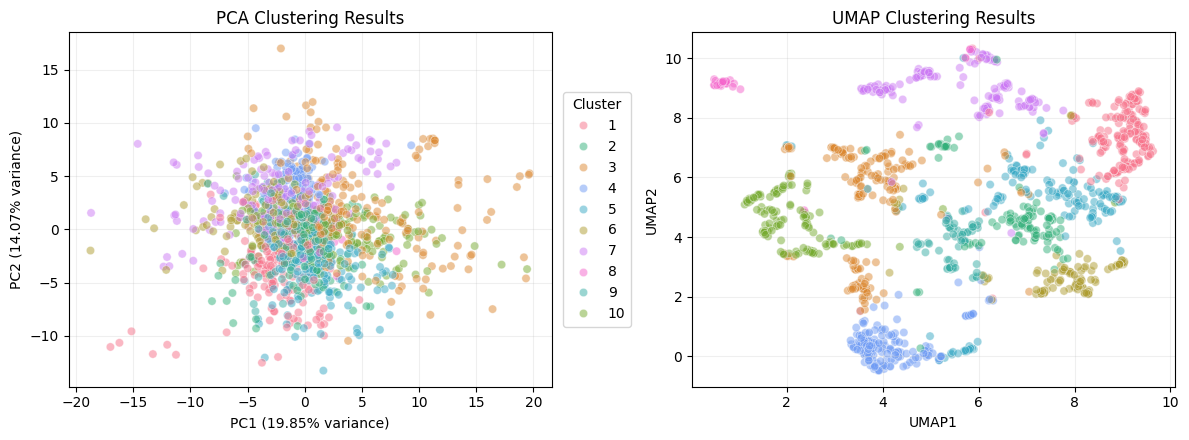

In [253]:
from adjustText import adjust_text

# Get unique clusters and create color palette
n_clusters = len(np.unique(dr_res_df["Metadata_cluster"]))
colors = sns.color_palette("husl", n_clusters)
color_map = {cluster: colors[i] for i, cluster in enumerate(dr_res_df["Metadata_cluster"].unique())}
auroc_thres = 0.95

fig, ax = plt.subplots(1,2, figsize=(12, 4.5))
# PCA plot
sns.scatterplot(
    dr_res_df,
    x="PC1",
    y="PC2",
    hue="Metadata_cluster",
    palette=color_map,
    ax=ax[0],
    alpha=.5,
    # legend=False
)
# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax[0].set_title('PCA Clustering Results')
ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', title="Cluster", ncol=1)

# PCA plot
sns.scatterplot(
    dr_res_df,
    x="UMAP1",
    y="UMAP2",
    hue="Metadata_cluster",
    palette=color_map,
    ax=ax[1],
    alpha=.5,
    legend=False
)
# Add text labels for high-scoring points in PCA
high_score_mask = dr_res_df['Metadata_Altered_95th_perc_both_batches_GFP_ADJ']==True

# ax[1].get_legend().remove()

texts_pca = []
# for idx in dr_res_df[high_score_mask].index:
#    texts_pca.append(
#       ax[0].text(
#        dr_res_df.loc[idx, 'PC1'],
#        dr_res_df.loc[idx, 'PC2'],
#        str(idx),
#        fontsize=8
#    ))
# adjust_text(texts_pca, ax=ax[0], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Add text labels for high-scoring points in UMAP
texts_umap = []
# for idx in dr_res_df[high_score_mask].index:
#    texts_umap.append(ax[1].text(
#        dr_res_df.loc[idx, 'UMAP1'],
#        dr_res_df.loc[idx, 'UMAP2'],
#        str(idx),
#        fontsize=8
#    ))
# adjust_text(texts_umap, ax=ax[1], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[1].scatter(embedding[mask, 0], embedding[mask, 1],
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)

ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('UMAP Clustering Results')

ax[0].grid(alpha=.2)
ax[1].grid(alpha=.2)
plt.subplots_adjust(wspace=.3)
plt.tight_layout()
plt.show()

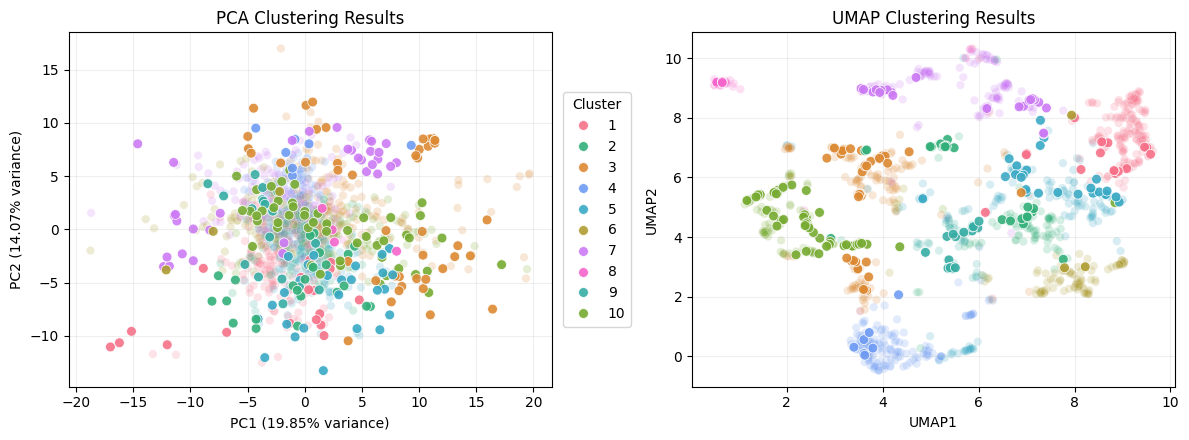

In [254]:
from adjustText import adjust_text

# Get unique clusters and create color palette
n_clusters = len(np.unique(dr_res_df["Metadata_cluster"]))
colors = sns.color_palette("husl", n_clusters)
color_map = {cluster: colors[i] for i, cluster in enumerate(dr_res_df["Metadata_cluster"].unique())}

fig, ax = plt.subplots(1,2, figsize=(12, 4.5))
# PCA plot
sns.scatterplot(
    dr_res_df.loc[[i for i in dr_res_df.index if i not in misloc_ref_var_alleles],:],
    x="PC1",
    y="PC2",
    hue="Metadata_cluster",
    # color="lightgrey",
    palette=color_map,
    ax=ax[0],
    alpha=.2,
    legend=False
)
sns.scatterplot(
    dr_res_df.loc[[i for i in dr_res_df.index if i in misloc_ref_var_alleles],:],
    x="PC1",
    y="PC2",
    hue="Metadata_cluster",
    palette=color_map,
    ax=ax[0],
    alpha=.9,
    s=50,
    # legend=False
)
# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax[0].set_title('PCA Clustering Results')
ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', title="Cluster", ncol=1)

# PCA plot
sns.scatterplot(
    dr_res_df.loc[[i for i in dr_res_df.index if i not in misloc_ref_var_alleles],:],
    x="UMAP1",
    y="UMAP2",
    hue="Metadata_cluster",
    # color="lightgrey",
    palette=color_map,
    ax=ax[1],
    alpha=.2,
    legend=False
)
sns.scatterplot(
    dr_res_df.loc[[i for i in dr_res_df.index if i in misloc_ref_var_alleles],:],
    x="UMAP1",
    y="UMAP2",
    hue="Metadata_cluster",
    palette=color_map,
    ax=ax[1],
    alpha=.9,
    s=50,
    # style="x",
    legend=False
)
# Add text labels for high-scoring points in PCA
high_score_mask = dr_res_df['Metadata_Altered_95th_perc_both_batches_GFP_ADJ']==True

# ax[1].get_legend().remove()

texts_pca = []
# for idx in dr_res_df[high_score_mask].index:
#    texts_pca.append(
#       ax[0].text(
#        dr_res_df.loc[idx, 'PC1'],
#        dr_res_df.loc[idx, 'PC2'],
#        str(idx),
#        fontsize=8
#    ))
# adjust_text(texts_pca, ax=ax[0], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Add text labels for high-scoring points in UMAP
texts_umap = []
# for idx in dr_res_df[high_score_mask].index:
#    texts_umap.append(ax[1].text(
#        dr_res_df.loc[idx, 'UMAP1'],
#        dr_res_df.loc[idx, 'UMAP2'],
#        str(idx),
#        fontsize=8
#    ))
# adjust_text(texts_umap, ax=ax[1], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[1].scatter(embedding[mask, 0], embedding[mask, 1],
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)

ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('UMAP Clustering Results')

ax[0].grid(alpha=.2)
ax[1].grid(alpha=.2)
plt.subplots_adjust(wspace=.3)
plt.tight_layout()
plt.show()

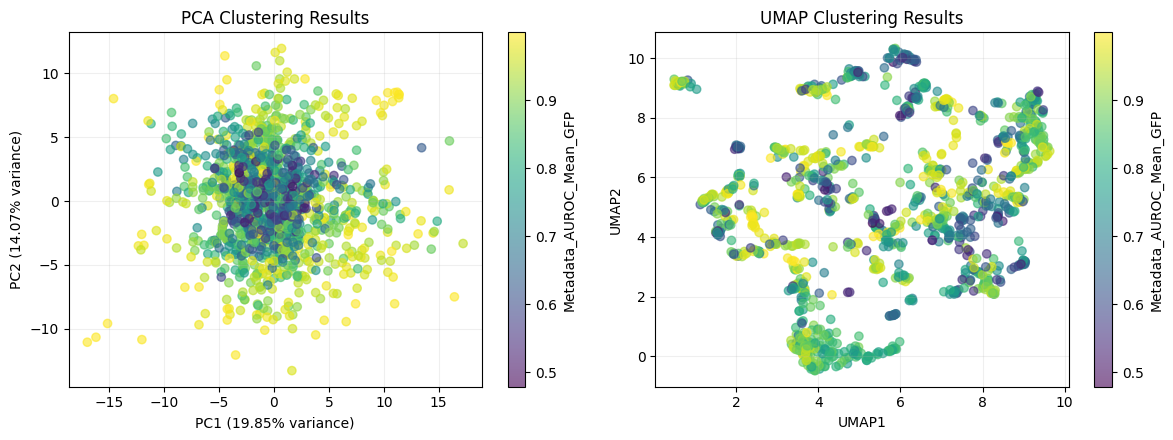

In [255]:
from matplotlib.colors import Normalize

# Create normalization and colormap for continuous scores
norm = Normalize(vmin=dr_res_df['Metadata_AUROC_Mean_GFP_ADJ'].min(), vmax=dr_res_df['Metadata_AUROC_Mean_GFP_ADJ'].max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(1,2, figsize=(12, 4.5))
# PCA plot
scatter1 = ax[0].scatter(
    dr_res_df['PC1'],
    dr_res_df['PC2'],
    c=dr_res_df["Metadata_AUROC_Mean_GFP_ADJ"],
    cmap=cmap,
    alpha=.6,
    # legend=False
)
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax[0].set_title('PCA Clustering Results')
# ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', title="Cluster", ncol=1)
plt.colorbar(scatter1, ax=ax[0], label='Metadata_AUROC_Mean_GFP')

# PCA plot
scatter2 = ax[1].scatter(
    dr_res_df['UMAP1'],
    dr_res_df['UMAP2'],
    c=dr_res_df["Metadata_AUROC_Mean_GFP_ADJ"],
    cmap=cmap,
    alpha=.6,
)

ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('UMAP Clustering Results')
plt.colorbar(scatter2, ax=ax[1], label='Metadata_AUROC_Mean_GFP')
ax[0].grid(alpha=.2)
ax[1].grid(alpha=.2)
plt.subplots_adjust(wspace=.3)
plt.tight_layout()
plt.show()

In [256]:
pca_loadings_df = pd.DataFrame(
    pca.components_,
    index=[f"PC{i}" for i in range(1, pca.components_.shape[1]+1)],
    columns=df.columns
).T
pca_loadings_df.sort_values(by=["PC1","PC2"],ascending=[False,False])

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109
Cells_RadialDistribution_FracAtD_GFP_10of10,0.138789,0.136301,-0.025765,-0.089962,-0.014239,-0.023448,0.013781,0.091601,-0.058831,0.017933,...,0.074757,-0.162803,0.250329,0.124325,-0.094486,-0.218226,0.015700,0.434814,-0.041766,-0.038682
Cells_RadialDistribution_MeanFrac_GFP_10of10,0.137114,0.150882,-0.022747,-0.079098,-0.040420,0.097561,0.012368,-0.048212,0.037154,-0.014685,...,0.098381,0.114308,-0.096410,-0.153773,0.113346,0.063254,0.030597,-0.631192,0.000201,0.055834
Nuclei_Correlation_Overlap_AGP_GFP,0.135410,-0.040607,-0.125672,-0.006856,-0.010915,0.116589,-0.014156,-0.050120,-0.181271,-0.036355,...,0.019949,0.117972,0.017897,0.021395,-0.043930,-0.011369,0.045598,-0.023129,0.014456,0.012257
Nuclei_Correlation_K_GFP_AGP,0.125748,-0.110436,0.110100,-0.084665,0.043772,0.014002,0.002214,-0.087992,-0.028067,0.009427,...,-0.020077,-0.074018,-0.066823,0.033197,0.042750,0.108124,-0.050582,0.029293,0.014202,0.000081
Cells_Texture_InfoMeas1_GFP_20_02_256,0.120329,-0.100642,0.144965,-0.078667,0.048077,0.068717,-0.047335,0.054107,0.077764,-0.006508,...,0.176511,-0.210424,-0.046177,-0.140869,-0.029115,0.110519,0.329716,-0.074745,-0.010682,-0.025007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nuclei_Intensity_MassDisplacement_GFP,-0.165320,0.030778,0.079504,-0.027433,-0.081284,0.106083,0.038490,0.016181,-0.088614,0.045817,...,-0.094519,0.000775,0.018551,-0.071541,0.073077,-0.048608,-0.043349,-0.027001,0.001390,-0.010343
Cells_RadialDistribution_RadialCV_GFP_2of10,-0.169063,0.023027,0.096638,0.008810,-0.036548,0.090399,0.006965,0.016757,0.044563,0.016599,...,0.082126,0.026449,0.047364,-0.061717,0.084750,-0.045889,0.004546,-0.004424,-0.077554,-0.009372
Cells_RadialDistribution_RadialCV_GFP_9of10,-0.169209,0.055089,-0.036589,0.021981,-0.058665,0.024571,-0.091475,-0.016210,0.042141,0.060677,...,0.091850,-0.259603,0.044072,0.073194,0.058515,-0.038775,-0.073547,-0.029379,0.025293,0.034930
Cells_Granularity_2_GFP,-0.170656,0.007842,0.064567,0.005776,0.008279,0.102676,0.082597,0.036275,0.058387,0.026657,...,0.017483,0.127863,-0.058376,0.123709,-0.279657,0.149110,0.074540,-0.037741,-0.450573,-0.130372


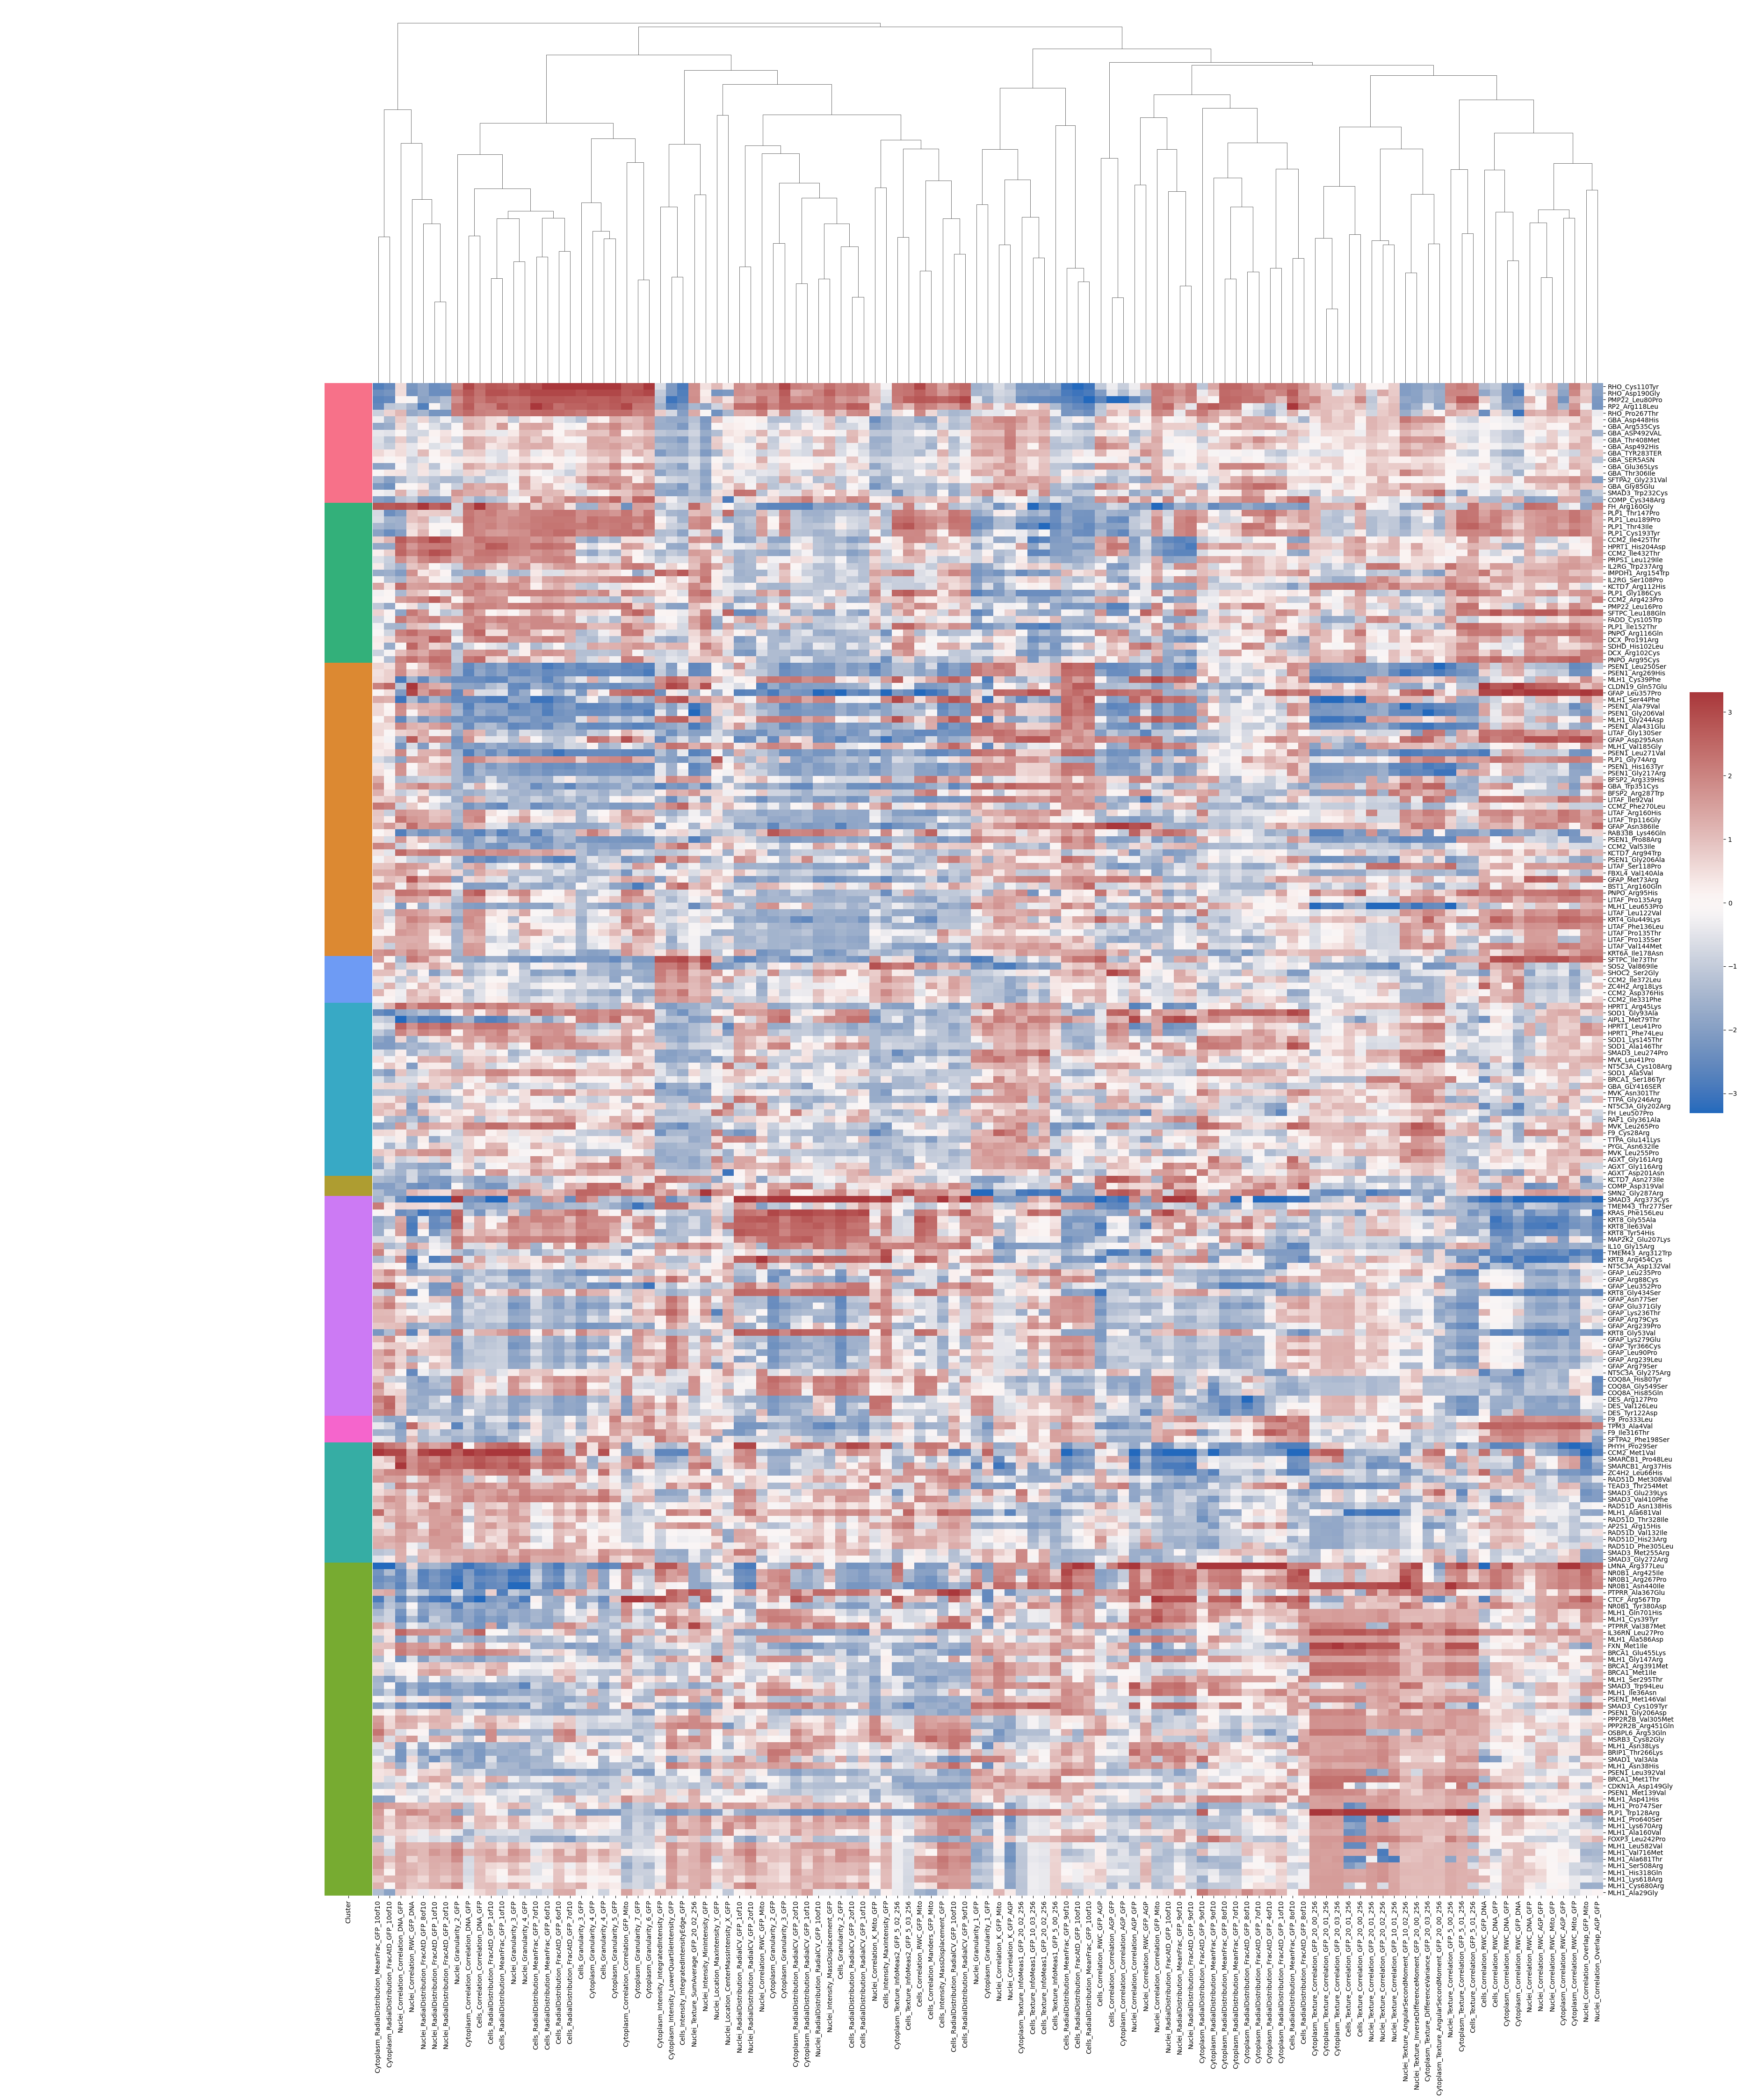

In [257]:
# Get cluster order from UMAP clustering
cluster_order = dr_res_df.sort_values('Metadata_cluster')['Metadata_cluster'].unique()

# Create cluster color mapping
n_clusters = len(np.unique(dr_res_df["Metadata_cluster"]))
cluster_colors = sns.color_palette("husl", n_clusters)
cluster_color_map = {cluster: cluster_colors[i] for i, cluster in enumerate(dr_res_df["Metadata_cluster"].unique())}

# Create ordered list based on clusters, then by score within clusters
ordered_variants = []
cluster_labels = []
for cluster in cluster_order:
#    print(cluster)
   cluster_variants = dr_res_df[dr_res_df['Metadata_cluster']==cluster].sort_values('Metadata_AUROC_Mean_GFP_ADJ', ascending=False).index.tolist()
   ordered_variants.extend(cluster_variants)
#    print(len(ordered_variants))
   cluster_labels.extend([cluster] * len(cluster_variants))

available_variants = []
available_cluster_labels = []
for i, variant in enumerate(ordered_variants):
   if variant in dr_res_df.sort_values('Metadata_AUROC_Mean_GFP_ADJ').index:
       available_variants.append(variant)
       available_cluster_labels.append(cluster_labels[i])
       
## Combine both color arrays as separate columns
row_colors_df = pd.DataFrame(index=ordered_variants)
row_colors_df['Cluster'] = [cluster_color_map[cluster] for cluster in available_cluster_labels]
# row_colors_df['AUROC_GFP'] = list(auroc_colors)

sns.clustermap(
    data=df.loc[[idx for idx in row_colors_df.index if idx in misloc_ref_var_alleles],:],
    cmap="vlag",
    center=0,
    row_colors=row_colors_df.loc[[idx for idx in row_colors_df.index if idx in misloc_ref_var_alleles],:],
    row_cluster=False,
    col_cluster=True,
    cbar_pos=(1.005, 0.47, 0.02, 0.2),
    figsize=(36, 45),
    yticklabels=1, 
    # xticklabels=1,
    # dendrogram_ratio=0
)
plt.show()

In [258]:
mislocalized_variant_cluster_df = df.loc[[idx for idx in row_colors_df.index if idx in misloc_ref_var_alleles],:].merge(
    dr_res_df.rename(
    {k : f"Metadata_{k}" for k in dr_res_df.columns if "Metadata" not in k},
    axis=1
),
    left_index=True, right_index=True
)
mislocalized_variant_cluster_df.to_csv("../outputs/mislocalized_variant_cluster.csv")

In [259]:
!python "cluster_disease_module_analysis_improved.py"

2025-09-22 00:30:45,912 - INFO - Loading cluster data...
2025-09-22 00:30:45,922 - INFO - Loading disease modules...
2025-09-22 00:30:45,936 - INFO - Loaded 227 variants across 10 clusters
2025-09-22 00:30:45,936 - INFO - Found 109 feature columns
2025-09-22 00:30:45,936 - INFO - Performing cluster feature analysis...
2025-09-22 00:30:45,936 - INFO - Analyzing cluster 1
2025-09-22 00:30:46,027 - INFO - Cluster 1: 50 significant features out of 109
2025-09-22 00:30:46,027 - INFO - Analyzing cluster 2
2025-09-22 00:30:46,116 - INFO - Cluster 2: 64 significant features out of 109
2025-09-22 00:30:46,116 - INFO - Analyzing cluster 3
2025-09-22 00:30:46,205 - INFO - Cluster 3: 83 significant features out of 109
2025-09-22 00:30:46,205 - INFO - Analyzing cluster 4
2025-09-22 00:30:46,652 - INFO - Cluster 4: 31 significant features out of 109
2025-09-22 00:30:46,652 - INFO - Analyzing cluster 5
2025-09-22 00:30:46,740 - INFO - Cluster 5: 48 significant features out of 109
2025-09-22 00:30:46,

## 6. Significant Features

In [260]:
sig_feat_df = pl.read_csv("../outputs/cluster_disease_module_analysis_comprehensive.csv")
sig_feat_df

cluster_id,cluster_size,feature_rank,feature_name,feature_p_adj,feature_neg_log10_padj,feature_fold_change,feature_cohens_d,feature_significant,module_rank,disease_module,module_confidence,is_primary_module
i64,i64,i64,str,f64,f64,f64,f64,bool,i64,str,f64,bool
1,18,1,"""Cytoplasm_Granularity_5_GFP""",1.5422e-7,6.811856,2.090482,1.746826,true,1,"""Neuropathy""",0.8,true
1,18,1,"""Cytoplasm_Granularity_5_GFP""",1.5422e-7,6.811856,2.090482,1.746826,true,2,"""Other_Genetic_Disorders""",0.5,false
1,18,2,"""Cells_Intensity_IntegratedInte…",0.000001,5.898025,-1.833711,-1.386331,true,1,"""Neuropathy""",0.8,true
1,18,2,"""Cells_Intensity_IntegratedInte…",0.000001,5.898025,-1.833711,-1.386331,true,2,"""Other_Genetic_Disorders""",0.5,false
1,18,3,"""Cytoplasm_Granularity_4_GFP""",0.000011,4.948036,1.829323,1.42324,true,1,"""Neuropathy""",0.8,true
…,…,…,…,…,…,…,…,…,…,…,…,…
10,50,3,"""Nuclei_Texture_Correlation_GFP…",3.5376e-16,15.451289,1.565731,1.379795,true,2,"""Other_Genetic_Disorders""",0.5,false
10,50,4,"""Cytoplasm_Texture_Correlation_…",3.5376e-16,15.451289,1.817713,1.512567,true,1,"""Cancer_Syndromes""",0.8,true
10,50,4,"""Cytoplasm_Texture_Correlation_…",3.5376e-16,15.451289,1.817713,1.512567,true,2,"""Other_Genetic_Disorders""",0.5,false


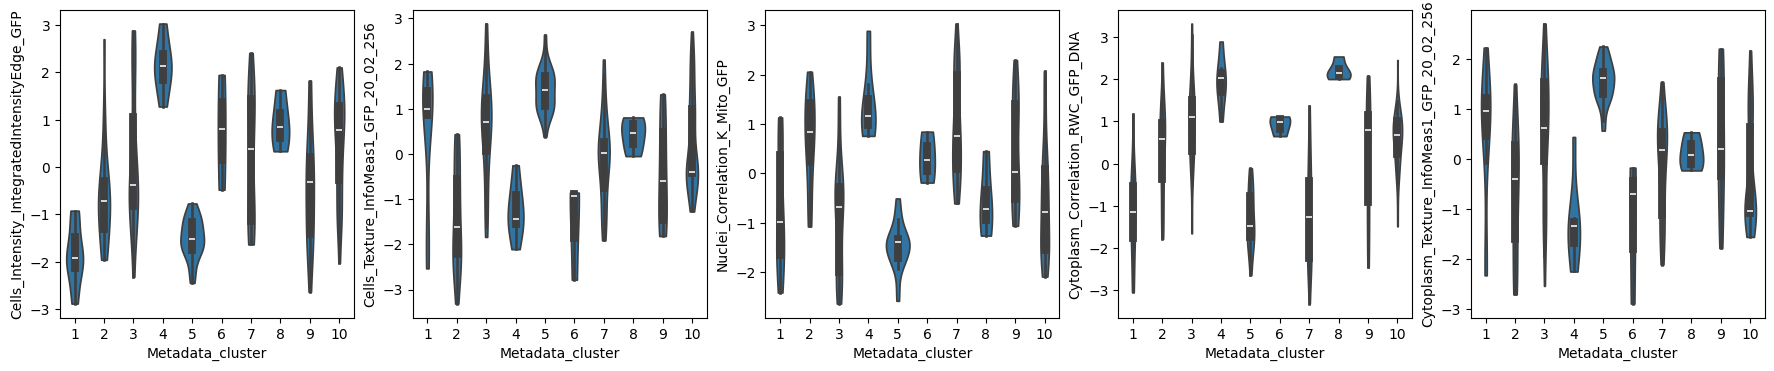

In [263]:
cluster_id = 5
sig_feats = sig_feat_df.filter(pl.col("cluster_id")==cluster_id)["feature_name"].unique()
fig, axes = plt.subplots(1,5,figsize=(22,4))
for i, sig_feat in enumerate(sig_feats):
    sns.violinplot(
        data=mislocalized_variant_cluster_df,
        x="Metadata_cluster",
        y=sig_feat,
        ax=axes[i],
        cut=0
    )

In [ ]:
# cluster_var_df[["Metadata_OMIM_disease_names"]+list(sig_feats)].to_csv("cluster5.csv")

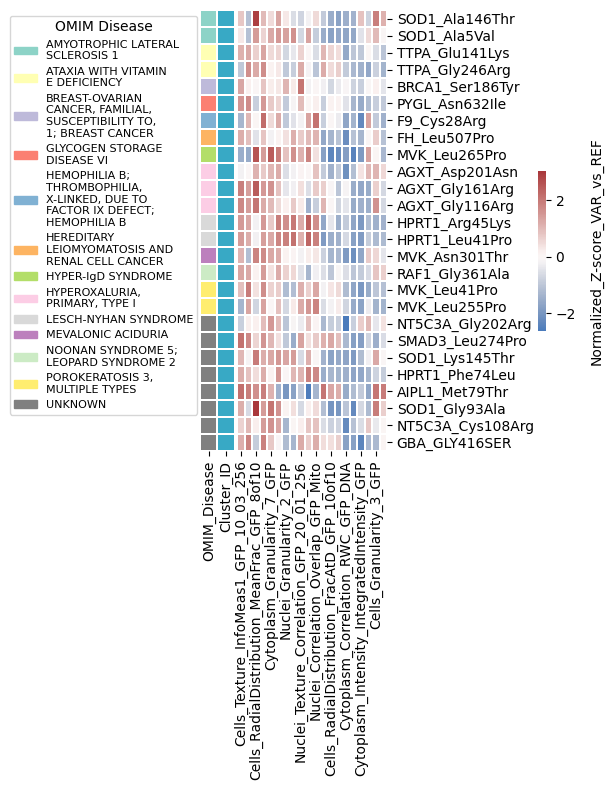

In [409]:
cluster_var_df = (
    mislocalized_variant_cluster_df
    .loc[mislocalized_variant_cluster_df["Metadata_cluster"] == cluster_id]
    .copy()
)
cluster_var_df["Metadata_OMIM_disease_names"] = cluster_var_df["Metadata_OMIM_disease_names"].fillna("UNKNOWN")
cluster_var_df = cluster_var_df.sort_values("Metadata_OMIM_disease_names")

unique_diseases = cluster_var_df["Metadata_OMIM_disease_names"].unique()
color_disease = dict(zip(unique_diseases, sns.color_palette("Set3", len(unique_diseases))))
color_disease["UNKNOWN"] = "grey"  # Override Unknown color

clusterow_colors_df_disease = pd.DataFrame(index=cluster_var_df.index)
clusterow_colors_df_disease["OMIM_Disease"] = cluster_var_df["Metadata_OMIM_disease_names"].map(color_disease)
clusterow_colors_df_disease["Cluster_ID"] = cluster_var_df["Metadata_cluster"].map(cluster_color_map)

g = sns.clustermap(
    data=cluster_var_df[sig_feats],
    cmap="vlag", 
    center=0,
    row_colors=clusterow_colors_df_disease,
    row_cluster=False,
    colors_ratio=0.08,
    cbar_pos=(.97, 0.58, 0.02, 0.2),
    figsize=(4,8),
    dendrogram_ratio=(0.15, 0),
    linewidths=0.1
)
g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', rotation=90, labelpad=10)
# Add legend
# Add legend with smaller font and line wrapping
import textwrap
handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_disease.values()]
labels = ['\n'.join(textwrap.wrap(label, width=20)) for label in color_disease.keys()]
g.ax_col_dendrogram.legend(handles, labels, title="OMIM Disease", 
                          bbox_to_anchor=(-0.23, .5), loc='upper right',fontsize=8.)

# handles = [plt.Rectangle((0,0),1,1, color=color) for color in cluster_color_map.values()]
# labels = [label for label in cluster_color_map.keys()]
# g.ax_col_dendrogram.legend(handles, labels, title="OMIM Disease", 
#                           bbox_to_anchor=(-0.1, .5), loc='lower right')

In [410]:
cluster_var_df.shape

(26, 224)

In [401]:
sig_feat_df

cluster_id,cluster_size,feature_rank,feature_name,feature_p_adj,feature_neg_log10_padj,feature_fold_change,feature_cohens_d,feature_significant,module_rank,disease_module,module_confidence,is_primary_module
i64,i64,i64,str,f64,f64,f64,f64,bool,i64,str,f64,bool
1,18,1,"""Cytoplasm_Granularity_5_GFP""",1.5422e-7,6.811856,2.090482,1.746826,true,1,"""Neuropathy""",0.8,true
1,18,1,"""Cytoplasm_Granularity_5_GFP""",1.5422e-7,6.811856,2.090482,1.746826,true,2,"""Other_Genetic_Disorders""",0.5,false
1,18,2,"""Cells_Intensity_IntegratedInte…",0.000001,5.898025,-1.833711,-1.386331,true,1,"""Neuropathy""",0.8,true
1,18,2,"""Cells_Intensity_IntegratedInte…",0.000001,5.898025,-1.833711,-1.386331,true,2,"""Other_Genetic_Disorders""",0.5,false
1,18,3,"""Cytoplasm_Granularity_4_GFP""",0.000011,4.948036,1.829323,1.42324,true,1,"""Neuropathy""",0.8,true
…,…,…,…,…,…,…,…,…,…,…,…,…
10,50,3,"""Nuclei_Texture_Correlation_GFP…",3.5376e-16,15.451289,1.565731,1.379795,true,2,"""Other_Genetic_Disorders""",0.5,false
10,50,4,"""Cytoplasm_Texture_Correlation_…",3.5376e-16,15.451289,1.817713,1.512567,true,1,"""Cancer_Syndromes""",0.8,true
10,50,4,"""Cytoplasm_Texture_Correlation_…",3.5376e-16,15.451289,1.817713,1.512567,true,2,"""Other_Genetic_Disorders""",0.5,false


In [ ]:
sig_feats = sig_feat_df.filter(pl.col("cluster_id")==cluster_id)["feature_name"].unique()

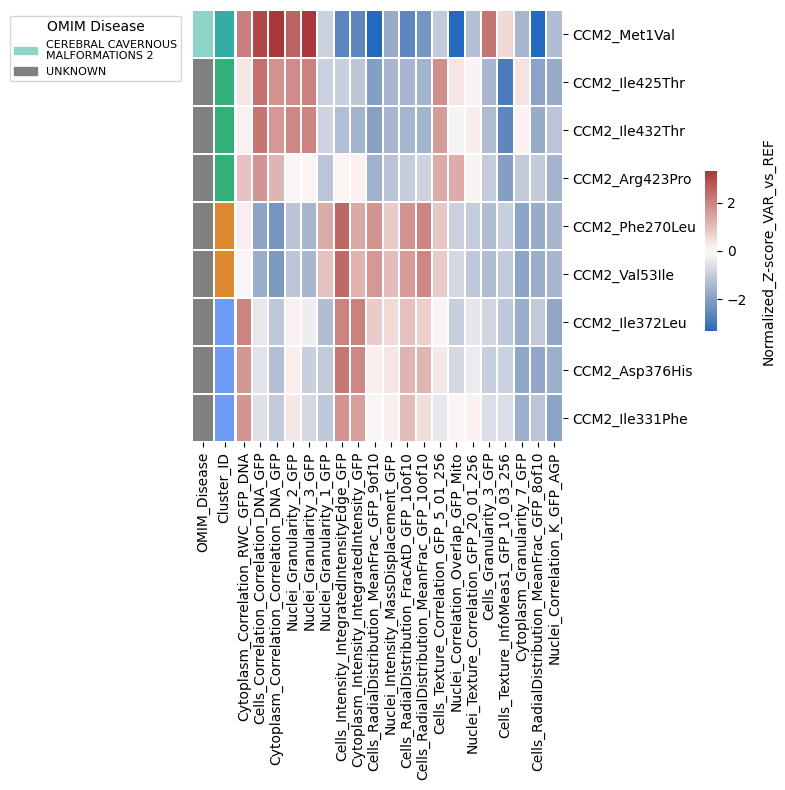

In [408]:
cluster_var_ccm2_df = (
    mislocalized_variant_cluster_df
    .loc[[i for i in mislocalized_variant_cluster_df.index if "CCM2" in i]]
    .copy()
)
cluster_id_list = set(cluster_var_ccm2_df["Metadata_cluster"])
sig_feats = sig_feat_df.filter(pl.col("cluster_id").is_in(cluster_id_list))["feature_name"].unique()

cluster_var_ccm2_df["Metadata_OMIM_disease_names"] = cluster_var_ccm2_df["Metadata_OMIM_disease_names"].fillna("UNKNOWN")
cluster_var_ccm2_df = cluster_var_ccm2_df.sort_values("Metadata_OMIM_disease_names")

unique_diseases = cluster_var_ccm2_df["Metadata_OMIM_disease_names"].unique()
color_disease = dict(zip(unique_diseases, sns.color_palette("Set3", len(unique_diseases))))
color_disease["UNKNOWN"] = "grey"  # Override Unknown color

clusterow_colors_df_disease = pd.DataFrame(index=cluster_var_ccm2_df.index)
clusterow_colors_df_disease["OMIM_Disease"] = cluster_var_ccm2_df["Metadata_OMIM_disease_names"].map(color_disease)
clusterow_colors_df_disease["Cluster_ID"] = cluster_var_ccm2_df["Metadata_cluster"].map(cluster_color_map)

g = sns.clustermap(
    data=cluster_var_ccm2_df[sig_feats],
    cmap="vlag", 
    center=0,
    row_colors=clusterow_colors_df_disease,
    row_cluster=False,
    colors_ratio=0.05,
    cbar_pos=(.99, 0.58, 0.02, 0.2),
    figsize=(6,8),
    dendrogram_ratio=(0.15, 0),
    linewidths=0.1
)
g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', rotation=90, labelpad=10)
# Add legend
# Add legend with smaller font and line wrapping
import textwrap
handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_disease.values()]
labels = ['\n'.join(textwrap.wrap(label, width=20)) for label in color_disease.keys()]
g.ax_col_dendrogram.legend(handles, labels, title="OMIM Disease", 
                          bbox_to_anchor=(-0.15, 0), loc='upper right',fontsize=8.)

# handles = [plt.Rectangle((0,0),1,1, color=color) for color in cluster_color_map.values()]
# labels = [label for label in cluster_color_map.keys()]
# g.ax_col_dendrogram.legend(handles, labels, title="OMIM Disease", 
#                           bbox_to_anchor=(-0.1, .5), loc='lower right')